<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/XGBoost/07_early_stopping_by_rounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install scikit-learn==1.5.2

In [65]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb

The objective of this mini project is to validate the early stopping behavior of the XGBoost library.

# **Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

The early stopping process will be applied to a binary classification problem.

# **Config**
---


In [66]:
sns.set(style="darkgrid")
sns.color_palette("tab10")
title_data = 'EarlyStopping'
random_seed=12354
warnings.filterwarnings("ignore")

# **DATA**
---

 Synthetic dataset of 1500 records and 20 features is generated, of which 18 are informative and 2 are redundant. The data has a separation of 0.01 with a cluster concentration of 4 and a classification error rate of 8%. The goal is for the data to be somewhat challenging

In [67]:
X, y = make_classification(
    n_samples=1500,
    n_features=20,
    n_informative=18,
    n_redundant=2,
    n_classes=2,
    flip_y=0.08,
    class_sep=0.01,
    n_clusters_per_class = 4,
    random_state=random_seed
)

**Data split**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=random_seed
)

Configuration function that allows setting up early stopping.

In [69]:
def define_earlyStopping(round:int=5, metric_name:str='error'):
  return xgb.callback.EarlyStopping(
      rounds = round,
      metric_name = metric_name
  )

In [70]:
early_stop = define_earlyStopping()

The model parameters are configured with 2000 estimators, a learning rate of 0.05, and the 'error' metric. Early stopping is configured for five rounds.

In [71]:
params = {
    'n_estimators': 2000,
    'random_state': random_seed,
    'learning_rate': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': "error",
    'callbacks': [early_stop]
}

In [72]:
model_five_rondas = xgb.XGBClassifier(**params)
model_five_rondas.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
results_five_rondas = model_five_rondas.evals_result()

To evaluate the behavior, a model was trained in parallel without the early stopping configuration.

In [76]:
del params['callbacks']
model_no_stop_ronda = xgb.XGBClassifier(**params)
model_no_stop_ronda.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
results_no_stop_rondas = model_no_stop_ronda.evals_result()

0.33866666666666667 26


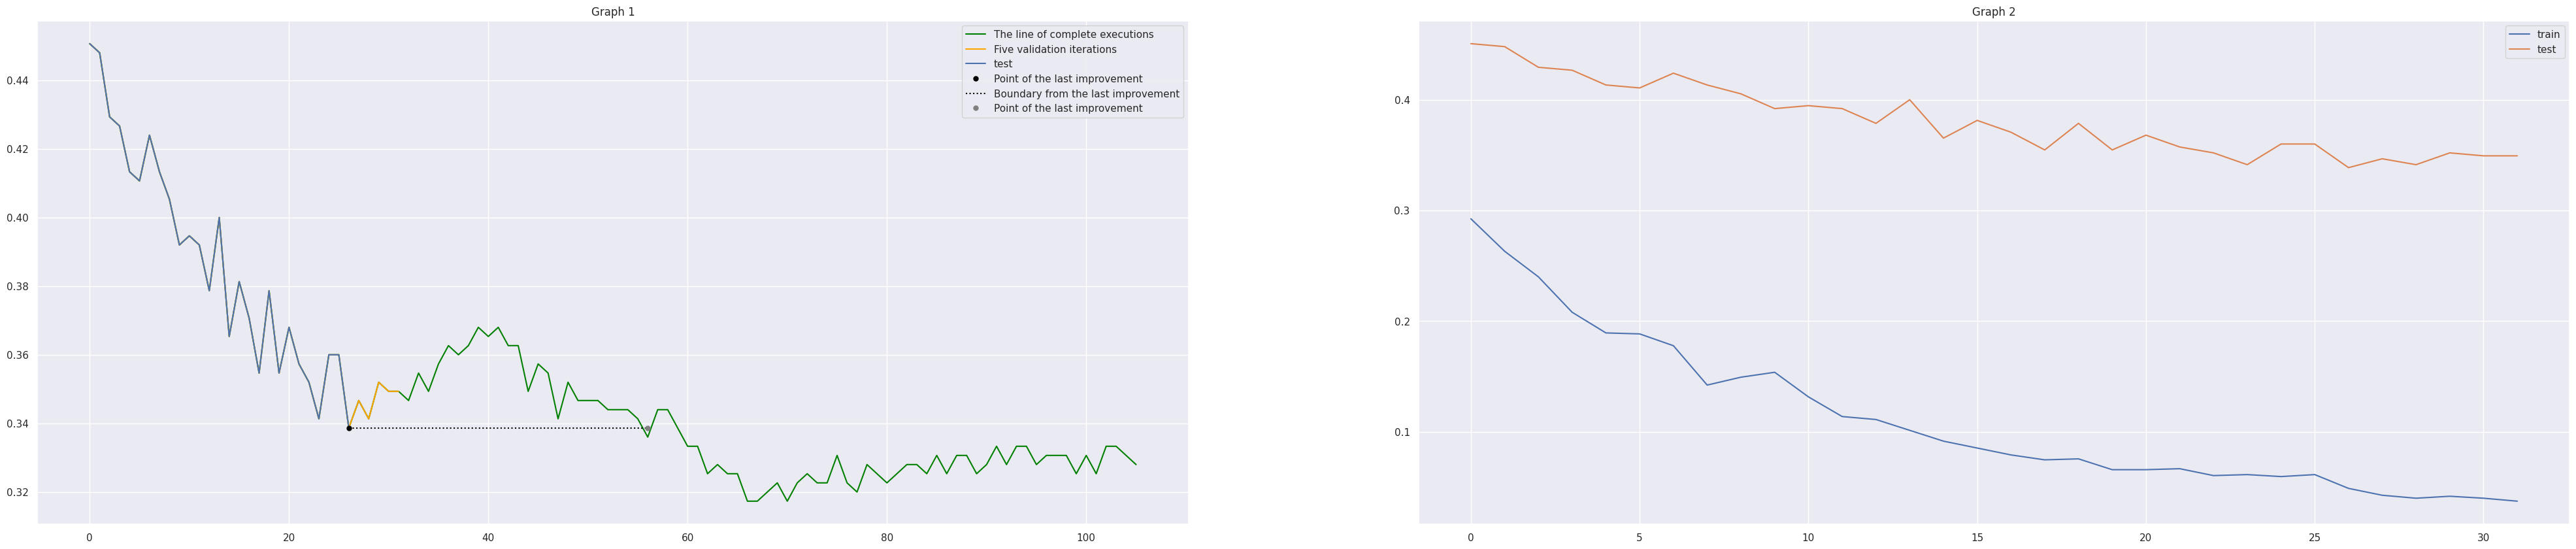

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50, 10))
error_last_round = results_five_rondas['validation_1']['error'][-6]
last_pos_round = len(results_five_rondas['validation_1']['error'])-6

print(error_last_round, last_pos_round)
ax[0].plot(results_no_stop_rondas['validation_1']['error'][:last_pos_round+80], label='The line of complete executions',  color='green')
ax[0].plot(results_five_rondas['validation_1']['error'], label='Five validation iterations', color='orange')
ax[0].plot(results_five_rondas['validation_1']['error'][:27], label='test')
ax[0].plot(last_pos_round, error_last_round, 'o', markersize=5, label='Point of the last improvement', color='black')
ax[0].plot([last_pos_round, last_pos_round+30], [error_last_round,error_last_round], label='Boundary from the last improvement', color='black', linestyle='dotted')
ax[0].plot(56, error_last_round, 'o', markersize=5, label='Point of the last improvement', color='gray')
ax[0].set_title('Graph 1')
ax[0].legend()
ax[1].plot(results_five_rondas['validation_0']['error'], label='train')
ax[1].plot(results_five_rondas['validation_1']['error'], label='test')
ax[1].set_title('Graph 2')
ax[1].legend()
plt.show()

**Analysis of Graph 1**

With the 5-round configuration, in the training set (orange line), it is evident that the model could not reduce the error below 0.338, as shown by the segment of the orange line.

The early stopping method is very effective in reducing unnecessary or unproductive learning time, as shown in Graph 2, where it is evident that the model configuration is not optimal, stopping the model at iteration 31 (estimator), thereby avoiding 1969 more iterations of training.

However, caution is needed when selecting the rounds, as the model could be biased or stop earlier than expected. In Graph 1, it is seen that the model could reduce the error at iteration 56 or at iteration 65, as shown by the points and the dashed line.

**Analysis of Graph 2**

The graph shows that there is no convergence when the model stopped due to early stopping after 5 rounds. This suggests that this method does not necessarily prevent overfitting; however, it can prevent unnecessary training, as it will stop when the error is no longer reduced, within the configured wait rounds.